<a href="https://colab.research.google.com/github/swapnasujith/AIML2swapnasajith/blob/main/self_supervised_learning_additional_layer_and_epoch_increase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self-Supervised learning

In this tutorial, we will work with CIFAR10 dataset to see how much we can learn about the data without using labels.

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import svm, metrics


## Get the CIFAR10 dataset

For this notebook, let us use only four classes from the CIFAR10 dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# Classes in CIFAR10
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# take only two classes: car, cat
index = torch.tensor(trainset.targets)==1
train_car_data = trainset.data[index]
index = torch.tensor(trainset.targets)==3
train_cat_data = trainset.data[index]

# generate randomized data
traindata = np.vstack((train_car_data, train_cat_data))
trainlabel = np.zeros(len(traindata))
trainlabel[5000:10000] = 1
index = np.random.permutation(len(traindata))
traindata = traindata[index, :,:,:]
trainlabel = trainlabel[index]

# create the test set

# take only two classes: car, cat
index = torch.tensor(testset.targets)==1
test_car_data = testset.data[index]
index = torch.tensor(testset.targets)==3
test_cat_data = testset.data[index]

# generate randomized data
testdata = np.vstack((test_car_data, test_cat_data))
testlabel = np.zeros(len(testdata))
testlabel[1000:2000] = 1
index = np.random.permutation(len(testdata))
testdata = testdata[index, :,:,:]
testlabel = testlabel[index]

100%|██████████| 170498071/170498071 [00:01<00:00, 98398147.89it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us visualize some images from the classes

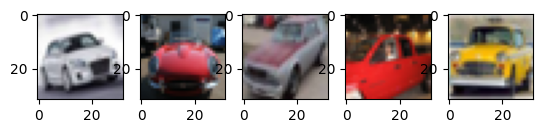

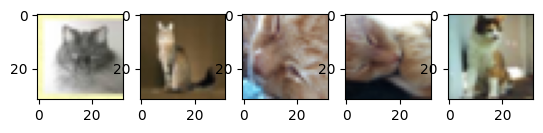

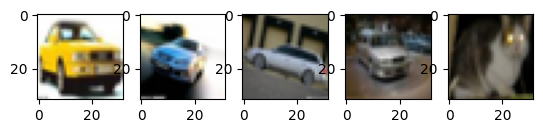

In [3]:
# car images
randind = torch.randint(len(train_car_data), size=(5,1))
fig, ax = plt.subplots(1, 5)
for ii in range(5):
  ax[ii].imshow(train_car_data[randind[ii]])

# cat images
randind = torch.randint(len(train_cat_data), size=(5,1))
fig, ax = plt.subplots(1, 5)
for ii in range(5):
  ax[ii].imshow(train_cat_data[randind[ii]])

# random images
randind = torch.randint(len(traindata), size=(5,1))
fig, ax = plt.subplots(1, 5)
for ii in range(5):
  ax[ii].imshow(traindata[randind[ii]])

Visualize a PCA-reduced data

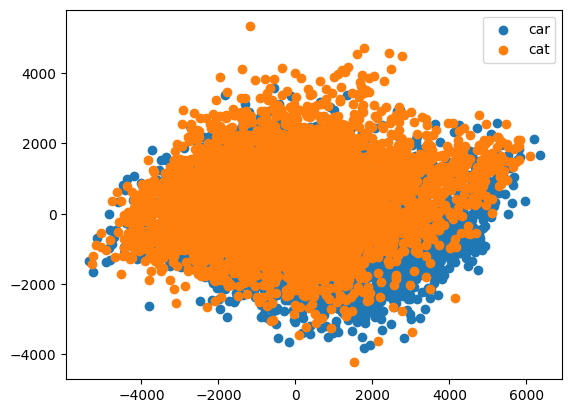

In [4]:
X = np.reshape(traindata, (len(traindata), -1))
pca = PCA(n_components=2).fit(X)
car_pca = pca.transform(np.reshape(train_car_data, (len(train_car_data), -1)))
plt.scatter(car_pca[:,0], car_pca[:,1])
cat_pca = pca.transform(np.reshape(train_cat_data, (len(train_cat_data), -1)))
plt.scatter(cat_pca[:,0], cat_pca[:,1])
plt.legend(['car','cat'])

We can see that the features of each overlap and there is no clear separation. This means that the input images by themselves are not good features.

---



# K-Means clustering directly on the image data

Let us see the mix of data in each cluster

In [5]:
def visualize_kmeans(kmeans):
  fig, ax = plt.subplots(1,2)

  # cluster = 0
  l_cluster = trainlabel[kmeans.labels_==0]
  class0 = np.sum(l_cluster==0)
  class1 = np.sum(l_cluster==1)
  ax[0].bar(['Car','Cat'],[class0,class1])

  # cluster = 1
  l_cluster = trainlabel[kmeans.labels_==1]
  class0 = np.sum(l_cluster==0)
  class1 = np.sum(l_cluster==1)
  ax[1].bar(['Car','Cat'],[class0,class1])


In [6]:
X = np.reshape(traindata, (len(traindata),-1))
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

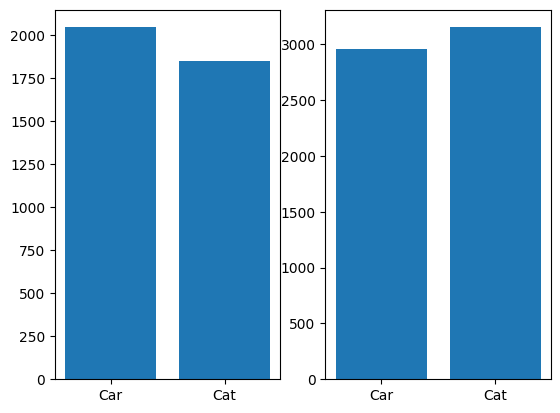

In [7]:
visualize_kmeans(kmeans)

# K-Means clustering on PCA-reduced data

Instead of applying K-means directly on the image data, let us first reduce the dimensionality of the image data from 32x32x3 to 10 and then apply kmeans

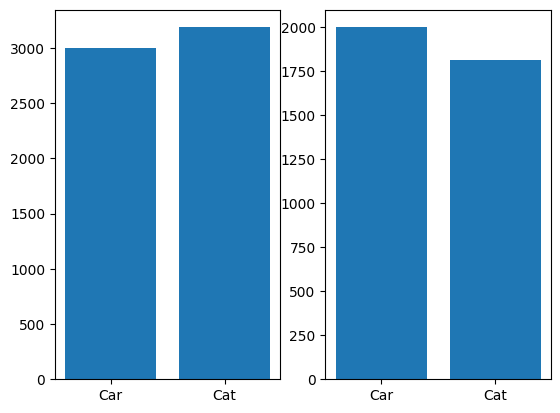

In [8]:
X = np.reshape(traindata, (len(traindata), -1))
pca = PCA(n_components=10).fit(X)
X_pca = pca.transform(X)
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_pca)
visualize_kmeans(kmeans)

# SVM on PCA-reduced data

We are using SVM instead of a deep network because we want a less powerful calssifier for this experiment.

Here. we will reduce the dimensions of our image data into 10 features and classify the features using SVM into car and cat

In [9]:
# reduce the dimensions to 10 using PCA
train = np.reshape(traindata, (len(traindata), -1))
pca = PCA(n_components=10).fit(X)
train_pca = pca.transform(X)
test = np.reshape(testdata, (len(testdata), -1))
test_pca = pca.transform(X)

# classify using SVM and see the accuracy
# create a model using SVM
clf = svm.LinearSVC()
clf.fit(train, trainlabel)
test_predict = clf.predict(test)
print("Accuracy:",metrics.accuracy_score(test_predict, testlabel))

Accuracy: 0.7535


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Embedding images using an auxiliary task

Let us use the task of predicting the orientation of an image to learn better features than PCA. We will have four classes: up, down, left and right. Here are what the images look like:

Text(0.5, 1.0, 'Up')

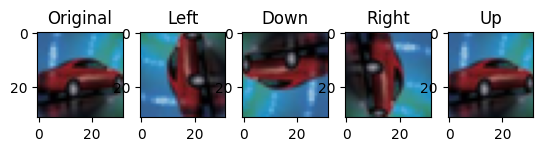

In [10]:
img = traindata[1001,:,:,:]
fig, ax = plt.subplots(1,5)
ax[0].imshow(img)
ax[0].set_title('Original')
img = np.rot90(img)
ax[1].imshow(img)
ax[1].set_title('Left')
img = np.rot90(img)
ax[2].imshow(img)
ax[2].set_title('Down')
img = np.rot90(img)
ax[3].imshow(img)
ax[3].set_title('Right')
img = np.rot90(img)
ax[4].imshow(img)
ax[4].set_title('Up')

Create a dataset for this task

In [11]:
class RotationData(torch.utils.data.Dataset):
  def __init__(self, data):
    super(RotationData, self).__init__()
    self.data=data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    img = torch.tensor(self.data[index]/255, dtype=torch.float32);
    # get a random class
    label = torch.randint(4,[1,1]).item()
    for ii in range(label):
      img = torch.rot90(img)
    img = img.permute(2,0,1) # make channels first
    return img, label

traindataset = RotationData(traindata)
dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testdataset = RotationData(testdata)

Define a model for our task. Notice that our final layer has output of size 4, for the four classes. The penultimate layer has size 10, because we want to obtain a size of 10.

In [44]:
# CNN with 2 CONV layers and 3 FC layers
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        # output layer 4 classes for each orientation
        self.fc4 = nn.Linear(10,4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    # so that we can get only the features
    def get_features(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      # flatten all dimensions except batch
      x = torch.flatten(x, 1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      return x

Training function

In [45]:
def train(num_epochs, model, train_loader, loss_func, optimizer):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    for i, (images, labels) in enumerate(train_loader):

      # clear gradients for this training step
      optimizer.zero_grad()

      # Forward pass
      output = model(images)

      # Calculate loss
      loss = loss_func(output, labels)

      # Backpropagation, compute gradients
      loss.backward()

      # Apply gradients
      optimizer.step()

      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels).sum()
      running_acc += correct

      # Average loss and acc values
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc)
    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100))

  return train_losses, train_acc

Let us train the model

In [46]:
# start with a fresh model
model = Net()
print(model)

# Cross Entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# SGD optimizer with momentum
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)



Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (fc4): Linear(in_features=10, out_features=4, bias=True)
)


In [47]:
num_epochs = 200  # iterations
train_losses, train_acc = train(num_epochs, model, dataloader, criterion, optimizer)

Epoch 1/200, Loss: 0.0112, Accuracy: 23.6000
Epoch 2/200, Loss: 0.0111, Accuracy: 27.4000
Epoch 3/200, Loss: 0.0111, Accuracy: 26.5500
Epoch 4/200, Loss: 0.0111, Accuracy: 24.2500
Epoch 5/200, Loss: 0.0111, Accuracy: 26.5500
Epoch 6/200, Loss: 0.0111, Accuracy: 24.8000
Epoch 7/200, Loss: 0.0111, Accuracy: 24.7500
Epoch 8/200, Loss: 0.0111, Accuracy: 25.6500
Epoch 9/200, Loss: 0.0111, Accuracy: 25.9000
Epoch 10/200, Loss: 0.0111, Accuracy: 24.6500
Epoch 11/200, Loss: 0.0111, Accuracy: 25.1500
Epoch 12/200, Loss: 0.0111, Accuracy: 26.9000
Epoch 13/200, Loss: 0.0110, Accuracy: 29.9500
Epoch 14/200, Loss: 0.0110, Accuracy: 30.6000
Epoch 15/200, Loss: 0.0110, Accuracy: 28.1500
Epoch 16/200, Loss: 0.0110, Accuracy: 29.7500
Epoch 17/200, Loss: 0.0109, Accuracy: 32.1500
Epoch 18/200, Loss: 0.0109, Accuracy: 30.4000
Epoch 19/200, Loss: 0.0109, Accuracy: 31.9000
Epoch 20/200, Loss: 0.0109, Accuracy: 36.3500
Epoch 21/200, Loss: 0.0107, Accuracy: 38.1000
Epoch 22/200, Loss: 0.0106, Accuracy: 40.60

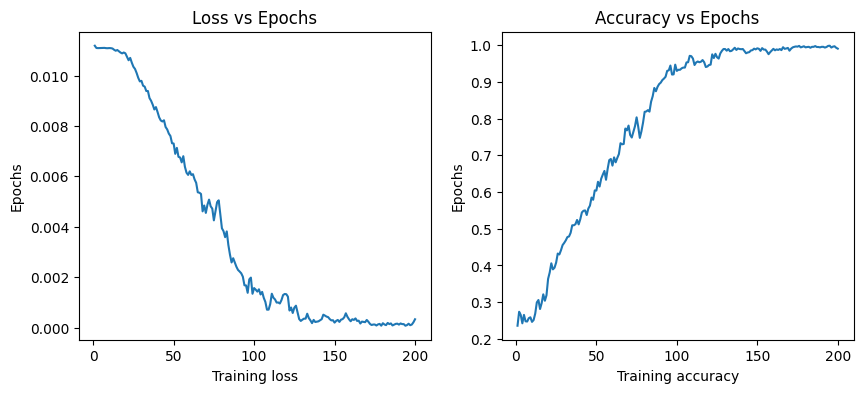

In [48]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(train_losses)+1),train_losses)
plt.xlabel('Training loss')
plt.ylabel('Epochs')
ax.set_title('Loss vs Epochs')
ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(train_acc)+1),train_acc)
plt.xlabel('Training accuracy')
plt.ylabel('Epochs')
ax.set_title('Accuracy vs Epochs')
plt.show()

Let us see how good these features are. First, we need to extract the features for our data.



In [49]:
trainfeatures = torch.zeros((len(traindataset), 10)) # 10 is the number of features
dataloader = torch.utils.data.DataLoader(traindataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
for i, (images, labels) in enumerate(dataloader):
  trainfeatures[i*batch_size: (i+1)*batch_size, :] = model.get_features(images)

trainfeatures = trainfeatures.data


testfeatures = torch.zeros((len(testdataset), 10)) # 10 is the number of features
dataloader = dataloader = torch.utils.data.DataLoader(testdataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
for i, (images, labels) in enumerate(dataloader):
  testfeatures[i*batch_size: (i+1)*batch_size, :] = model.get_features(images)

testfeatures = testfeatures.data

Run SVM and check the accuracy

In [50]:
clf = svm.LinearSVC()
clf.fit(trainfeatures, trainlabel)
test_predict = clf.predict(testfeatures)
print("Accuracy:",metrics.accuracy_score(test_predict, testlabel))

Accuracy: 0.717


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## KMeans on the features we found

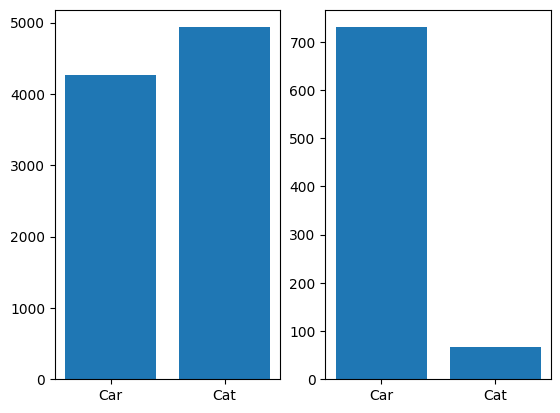

In [51]:
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(trainfeatures)
visualize_kmeans(kmeans)